# Boris Integrator

In [13]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import xarray as xr
from scipy import constants

import ggcmpy.tracing


def to_mesh_lines(df):
    positions = df[["x", "y", "z"]].values
    mesh = pv.PolyData(positions)
    lines = pv.lines_from_points(positions)
    return mesh, lines


def plot_trajectory(plotter, df, **kwargs):
    _, lines = to_mesh_lines(df)
    plotter.add_mesh(lines, **kwargs)

## Simple Gyration in a Uniform Magnetic Field


In [14]:
B_0 = 1e-8  # [T]
fields = ggcmpy.tracing.UniformField(B_0=np.array([0.0, 0.0, B_0]))

q = -constants.e
m = constants.m_e
x0 = np.array([0.0, 0.0, 0.0])  # [m]
v0 = np.array([0.0, 100.0, 0.0])  # [m/s]
om_ce = np.abs(q) * B_0 / m  # [rad/s]
t_max = 2 * np.pi / om_ce  # one gyroperiod # [s]
dt = t_max / 100  # [s]

boris = ggcmpy.tracing.BorisIntegrator(fields, q, m)
df = boris.integrate(x0, v0, t_max, dt)
df

,time,x,y,z,vx,vy,vz
0,0.000000,0.000000e+00,0.000000,0.0,0.000000,100.000000,0.0
1,0.000036,-1.121192e-04,0.003569,0.0,-6.276990,99.802803,0.0
2,0.000071,-4.480345e-04,0.007124,0.0,-12.529224,99.211988,0.0
3,0.000107,-1.006421e-03,0.010650,0.0,-18.732044,98.229886,0.0
4,0.000143,-1.785077e-03,0.014135,0.0,-24.860985,96.860371,0.0
...,...,...,...,...,...,...,...
96,0.003429,-1.814396e-03,-0.014249,0.0,25.061032,96.808805,0.0
97,0.003465,-1.028543e-03,-0.010766,0.0,18.934933,98.190979,0.0
98,0.003501,-4.628714e-04,-0.007240,0.0,12.734156,99.185893,0.0
99,0.003537,-1.196130e-04,-0.003686,0.0,6.483155,99.789622,0.0


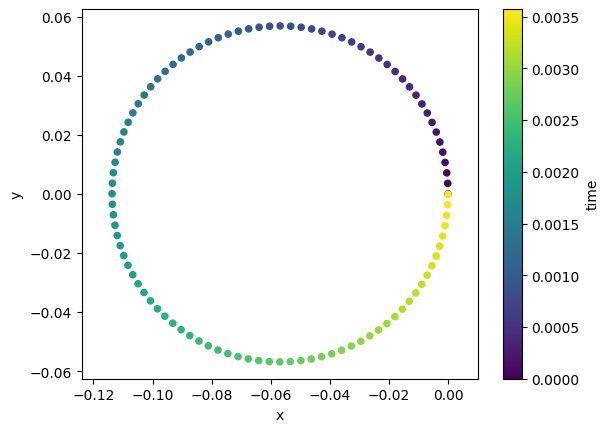

In [15]:
df.plot(x="x", y="y", c="time", kind="scatter")
plt.axis("equal");

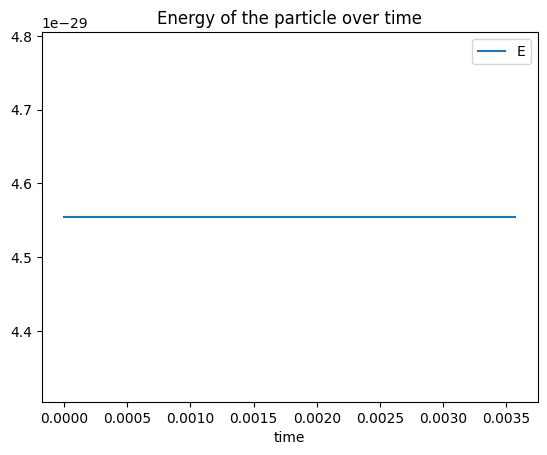

In [16]:
df["E"] = 0.5 * constants.m_e * np.linalg.norm(df[["vx", "vy", "vz"]].values, axis=1)
df.plot(x="time", y="E", title="Energy of the particle over time");

## Analytical and Discretized Dipole Field

In [17]:
field = ggcmpy.tracing.DipoleField(m=np.array([0.0, 0.0, 8e22]))  # [A m^2]

In [18]:
R_E = 6.371e6  # [m]

x0 = np.array([5.0 * R_E, 0.0, 0.0])  # [m]
B_x0 = field.B(x0)
T_e = 1.0 * 1e3 * constants.e  # 1 keV in J
v_e = np.sqrt(2 * T_e / constants.m_e)  # electron thermal speed
v_e *= 1000.0

om_ce = np.abs(constants.e) * np.linalg.norm(B_x0) / constants.m_e  # gyrofrequency
r_ce = constants.m_e * v_e / (constants.e * np.linalg.norm(field.B(x0)))  # gyroradius

v0 = np.array([0.0, v_e, v_e])  # [m/s]
print(f"B={B_x0} om_ce={om_ce} r_ce={r_ce}")  # noqa: T201

t_max = 100.0 * 2 * np.pi / om_ce  # [s]
dt = 1.0 / om_ce / 10.0

B=[ 0.00000000e+00  0.00000000e+00 -2.47489717e-07] om_ce=43528.98657512507 r_ce=430870.87671833555


In [19]:
x = np.linspace(-10 * R_E, 10 * R_E, 20)
y = np.linspace(-10 * R_E, 10 * R_E, 20)
z = np.linspace(-10 * R_E, 10 * R_E, 20)
x_nc = 0.5 * (x[1:] + x[:-1])
y_nc = 0.5 * (y[1:] + y[:-1])
z_nc = 0.5 * (z[1:] + z[:-1])
coords = {"x": x, "y": y, "z": z, "x_nc": x_nc, "y_nc": y_nc, "z_nc": z_nc}

In [20]:
b_grid = [("bx", ("x", "y", "z")), ("by", ("x", "y", "z")), ("bz", ("x", "y", "z"))]
e_grid = [("ex", ("x", "y", "z")), ("ey", ("x", "y", "z")), ("ez", ("x", "y", "z"))]

field_cc = xr.Dataset(
    ggcmpy.tracing.make_vector_field(b_grid, coords, field.B)
    | ggcmpy.tracing.make_vector_field(e_grid, coords, field.E),
    coords=coords,
)
field_cc

<xarray.Dataset> Size: 385kB
Dimensions:  (x: 20, y: 20, z: 20, x_nc: 19, y_nc: 19, z_nc: 19)
Coordinates:
  * x        (x) float64 160B -6.371e+07 -5.7e+07 ... 5.7e+07 6.371e+07
  * y        (y) float64 160B -6.371e+07 -5.7e+07 ... 5.7e+07 6.371e+07
  * z        (z) float64 160B -6.371e+07 -5.7e+07 ... 5.7e+07 6.371e+07
  * x_nc     (x_nc) float64 152B -6.036e+07 -5.365e+07 ... 5.365e+07 6.036e+07
  * y_nc     (y_nc) float64 152B -6.036e+07 -5.365e+07 ... 5.365e+07 6.036e+07
  * z_nc     (z_nc) float64 152B -6.036e+07 -5.365e+07 ... 5.365e+07 6.036e+07
Data variables:
    bx       (x, y, z) float64 64kB 5.954e-09 6.327e-09 ... 6.327e-09 5.954e-09
    by       (x, y, z) float64 64kB 5.954e-09 6.327e-09 ... 6.327e-09 5.954e-09
    bz       (x, y, z) float64 64kB -1.249e-24 -9.402e-10 ... -1.249e-24
    ex       (x, y, z) float64 64kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ey       (x, y, z) float64 64kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ez       (x, y, z) float64 64kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [21]:
b1_grid = [
    ("bx1", ("x_nc", "y", "z")),
    ("by1", ("x", "y_nc", "z")),
    ("bz1", ("x", "y", "z_nc")),
]
e1_grid = [
    ("ex1", ("x", "y_nc", "z_nc")),
    ("ey1", ("x_nc", "y", "z_nc")),
    ("ez1", ("x_nc", "y_nc", "z")),
]

field_yee = xr.Dataset(
    ggcmpy.tracing.make_vector_field(b1_grid, coords, field.B)
    | ggcmpy.tracing.make_vector_field(e1_grid, coords, field.E),
    coords=coords,
)

field_yee

<xarray.Dataset> Size: 357kB
Dimensions:  (x_nc: 19, y: 20, z: 20, x: 20, y_nc: 19, z_nc: 19)
Coordinates:
  * x        (x) float64 160B -6.371e+07 -5.7e+07 ... 5.7e+07 6.371e+07
  * y        (y) float64 160B -6.371e+07 -5.7e+07 ... 5.7e+07 6.371e+07
  * z        (z) float64 160B -6.371e+07 -5.7e+07 ... 5.7e+07 6.371e+07
  * x_nc     (x_nc) float64 152B -6.036e+07 -5.365e+07 ... 5.365e+07 6.036e+07
  * y_nc     (y_nc) float64 152B -6.036e+07 -5.365e+07 ... 5.365e+07 6.036e+07
  * z_nc     (z_nc) float64 152B -6.036e+07 -5.365e+07 ... 5.365e+07 6.036e+07
Data variables:
    bx1      (x_nc, y, z) float64 61kB 6.152e-09 6.579e-09 ... 6.152e-09
    by1      (x, y_nc, z) float64 61kB 6.152e-09 6.579e-09 ... 6.152e-09
    bz1      (x, y, z_nc) float64 61kB -4.437e-10 -1.49e-09 ... -4.437e-10
    ex1      (x, y_nc, z_nc) float64 58kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ey1      (x_nc, y, z_nc) float64 58kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ez1      (x_nc, y_nc, z) float64 58kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [22]:
boris = ggcmpy.tracing.BorisIntegrator(field, q=-constants.e, m=constants.m_e)
df = boris.integrate(x0, v0, t_max, dt)

In [23]:
boris_cc = ggcmpy.tracing.BorisIntegrator(field_cc, q=-constants.e, m=constants.m_e)
df_cc = boris_cc.integrate(x0, v0, t_max, dt)

In [24]:
boris_yee = ggcmpy.tracing.BorisIntegrator(
    ggcmpy.tracing.FieldInterpolatorYee_python(field_yee),
    q=-constants.e,
    m=constants.m_e,
)
df_yee = boris_yee.integrate(x0, v0, t_max, dt)

In [25]:
boris_f2py = ggcmpy.tracing.BorisIntegrator_f2py(
    field_yee,
    q=-constants.e,
    m=constants.m_e,
)
df_f2py = boris_f2py.integrate(x0, v0, t_max, dt)

In [26]:
plotter = pv.Plotter()
plot_trajectory(plotter, df, line_width=1, color="blue")
plot_trajectory(plotter, df_cc, line_width=1, color="red")
plot_trajectory(plotter, df_yee, line_width=1, color="green")
plot_trajectory(plotter, df_f2py, line_width=1, color="orange")
plotter.show()

Widget(value='<iframe src="http://localhost:62934/index.html?ui=P_0x321b44ad0_1&reconnect=auto" class="pyvista…